In [287]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import h5py

%matplotlib inline

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#####  Linear forward propagation & Linear Activation Forward

In [288]:
def linear_forward(A, W, b):
        
    Z = W.dot(A) + b
    
    cache = (A,W,b)
    
    return Z, cache


# Activation Functions for NN
def sigmoid(Z):
    
    A= 1 / (1 + np.exp(-Z))
    cache = Z
    
    return A, cache

def Relu(Z):
    
    A = np.maximum(0,Z)
    cache = Z
    
    return A, cache



# Linear to Activation Layer


def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        
        Z, lin_cache = linear_forward(A_prev, W, b)
        A, act_cache = sigmoid(Z)
        
    elif activation == "relu":
        
        Z, lin_cache = linear_forward(A_prev, W, b)
        A, act_cache = Relu(Z)
        
    cache = (lin_cache, act_cache)
    
    return A, cache

def L_model_forward(X, params):
    
    caches =[]
    A = X
    L = len(params) // 2
    
    for l in range(1, L):
        
        A_prev = A
        # Using Relu Activation function in Hidden Layers
        A, cache = linear_activation_forward(A_prev, params['W' + str(l)], params['b' + str(l)], "relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, params['W' + str(L)], params['b' + str(L)], "sigmoid")
    caches.append(cache)
    
    return AL, caches


#####  Cross-Entropy Cost Function

In [289]:
def cost_function(AL, Y):
    
    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
    loss = 1./m * np.nansum(logprobs)
    
    return loss

#####  Backward Propagation


In [290]:
def linear_backprop(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

def relu_backprop(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy = True)
    dZ[Z<= 0] = 0
    return dZ

def sigmoid_backprop(dA, cache):
    
    Z = cache
    s = 1/(1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    
    return dZ

def linear_activation_backprop(dA, cache, activation):
    
    lin_cache , act_cache = cache
    
    if activation == "relu":
        
        dZ = relu_backprop(dA, act_cache)
        dA_prev, dW, db = linear_backprop(dZ, lin_cache)
    
    elif activation == 'sigmoid':
        
        dZ = sigmoid_backprop(dA, act_cache)
        dA_prev, dW, db = linear_backprop(dZ, lin_cache)
        
    return dA_prev, dW, db

def L_model_backprop(AL, Y, caches):
    


    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y,AL) - np.divide(1-Y, 1-AL))
    
    current_cache = caches[L - 1]
    dA_prev_temp , dW_temp, db_temp = linear_activation_backprop(dAL, current_cache,"sigmoid")
    grads['dA' + str( L - 1)] = dA_prev_temp
    grads['dW' + str(L)] = dW_temp
    grads['db' + str(L)] = db_temp
    
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp , db_temp = linear_activation_backprop(grads['dA' + str(l + 1)], current_cache,'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+ 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    
    return grads



######  Parameters Update


In [291]:
def params_update(parameters, grads, alpha):
    
    L = len(parameters)//2
    
    for l in range(L):
        
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - alpha * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - alpha * grads["db" + str(l+1)]
    
    return parameters



##### Predict Function

In [292]:

def predict(X, y, parameters):

    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    

    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

##### Load dataset

In [293]:
import cv2
import os
import random

TRAINDIR = "train"
CATEGORIES = ['hot_dog', 'not_hot_dog']
IMG_SIZE = 100

def create_trainin_data():

    for ctg in CATEGORIES:
        path = os.path.join(TRAINDIR, ctg)
        label = CATEGORIES.index(ctg)
        
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_set.append([new_array, label])
            
training_set = []
create_trainin_data()
random.shuffle(training_set)

#preprocessing the data
X = []
y = []

for features, labels in training_set:
    X.append(features)
    y.append(labels)

X = np.array(X)
X = X.reshape(X.shape[0],-1).T
X = X/ 255
y = np.array(y)
y = y.reshape(1,y.shape[0])

#### Packing a L-Layer NN

In [294]:
#Structure 
def L_layer_model(X, Y, layers_dims, alpha = 0.0075, num_iters = 3000, print_cost = False):
    costs = []
    parameters = param_initialization_deep(layers_dims)

    for i in range(0,num_iters):
        AL, caches = L_model_forward(X, parameters)
        
        cost = cost_function(AL, Y)
        
        grads = L_model_backprop(AL, Y, caches)
        
        parameters = params_update(parameters, grads, alpha)
        
        if print_cost and i % 100 == 0 or i == num_iters - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iters:
            costs.append(cost)
    
    return parameters, costs

### Neural Network Tunning methods
##### 1. NN Parameters Initialization

In [295]:
### Option 1: Initialize parameters as 0s

def initialize_params_zeros(layer_dims):
    
    parameters = {}
    
    L = len(layer_dims)
    
    for l in range(1,L):
        
        parameters['W' + str(l)] = np.zeros((layer_dims[l],layer_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))        
    return parameters

### Option 2: Initialize parameters randomly

def initialize_params_random(layer_dims):
    
    parameters = {}
    L = len(layers_dims)            
    
    for l in range(1, L):
       
        parameters['W' + str(l) ] = np.random.randn(layer_dims[l] , layer_dims[l - 1]) * 10
        parameters['b' + str(l) ] = np.zeros((layer_dims[l],1))
        

    return parameters
### Option 3: He initialization

def initialize_params_He(layer_dims):
    
    parameters = {}
    L = len(layer_dims) - 1
    
    for l in range(1, L + 1):
        
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(2/ layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters

Initialization using zeros
Cost after iteration 0: 0.6931471805599453
Cost after iteration 1000: 0.6924308193604622
Cost after iteration 2000: 0.6924260015707088
Cost after iteration 2999: 0.6924259690876939


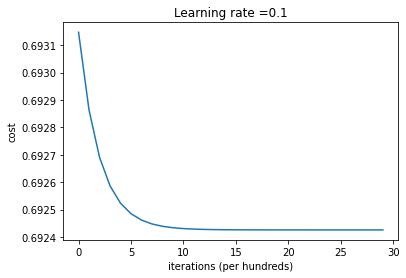

Initialization using He method
Cost after iteration 0: 1.100866306088878
Cost after iteration 1000: 0.43809586183242555
Cost after iteration 2000: 0.415080810656692
Cost after iteration 2999: 0.1572352071949043


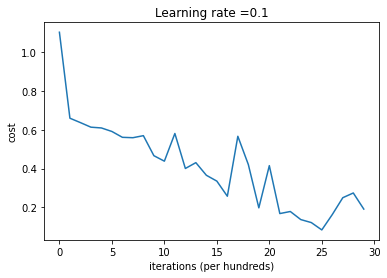

In [296]:
## Parameter Initialization with zeros

 
def L_layer_model(X, Y, layers_dims, alpha = 0.01, num_iters = 3000, print_cost = False, initialization = "he"):
    costs = []
    
    if initialization == "zeros":
        parameters = initialize_params_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_params_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_params_He(layers_dims)
        
    for i in range(0,num_iters):
        AL, caches = L_model_forward(X, parameters)

        cost = cost_function(AL, Y)

        grads = L_model_backprop(AL, Y, caches)
        
        parameters = params_update(parameters, grads, alpha)
        
        if print_cost and i % 1000 == 0 or i == num_iters - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iters:
            costs.append(cost)
    
    return parameters, costs

def plot_costs(costs, alpha=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(alpha))
    plt.show()
    

layers_dims = [X.shape[0],30,15,1]

print("Initialization using zeros")
parameters, costs = L_layer_model(X, y, layers_dims, num_iters = 3000, print_cost = True,initialization="zeros")
plot_costs(costs, 0.1)

# print("Initialization using random numbers")
# parameters, costs = L_layer_model(X, y, layers_dims, num_iters = 1000, print_cost = True,initialization="random")
# plot_costs(costs, alpha)

print("Initialization using He method")
parameters, costs = L_layer_model(X, y, layers_dims, num_iters = 3000, print_cost = True,initialization="he")
plot_costs(costs, 0.1)


### Neural Network Tunning methods
##### 2. Regularization
###### 2.1 Cost Function Regularization

In [297]:
def cost_function_reg(AL, Y, params, lambd):
    
    m = Y.shape[1]
    n = len(params) // 2
    Ws = []
    for l in range(1,n + 1):
        
        Ws.append(params['W' + str(l)] )
        
    CEC = cost_function(AL,Y)
    
    L2_cost = 1/m * lambd /2 * sum([np.sum(np.square(i)) for i in Ws])
    
    cost = CEC + L2_cost
    
    return cost

Initialization using He method with Regularized Cost Function
Cost after iteration 0: 0.8467634148667108
Cost after iteration 1000: 0.4263856704076404
Cost after iteration 2000: 0.2629124894518241
Cost after iteration 2999: 0.08890000903581763


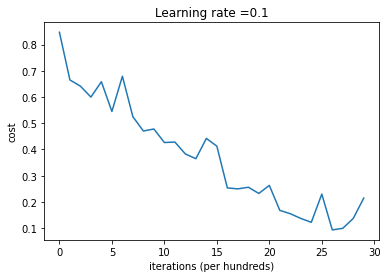

In [298]:
##  L2-Regulariztion

def L_layer_model(X, Y, layers_dims, alpha = 0.01, num_iters = 3000, print_cost = False, initialization = "he"):
    costs = []
    
    if initialization == "zeros":
        parameters = initialize_params_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_params_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_params_He(layers_dims)
        
    for i in range(0,num_iters):
        AL, caches = L_model_forward(X, parameters)

        cost = cost_function_reg(AL, Y,parameters, 0.1)

        grads = L_model_backprop(AL, Y, caches)
        
        parameters = params_update(parameters, grads, alpha)
        
        if print_cost and i % 1000 == 0 or i == num_iters - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iters:
            costs.append(cost)
    
    return parameters, costs

def plot_costs(costs, alpha=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(alpha))
    plt.show()
    

layers_dims = [X.shape[0],30,15,1]

print("Initialization using He method with Regularized Cost Function")
parameters, costs = L_layer_model(X, y, layers_dims, num_iters = 3000, print_cost = True,initialization="he")
plot_costs(costs, 0.1)


### Neural Network Tunning methods
##### 2. Regularization
###### 2.2 Backpropagation Regularization

Initialization Regularized Back propagation
Cost after iteration 0: 0.8593731786530213
Cost after iteration 1000: 0.4685519583793695
Cost after iteration 2000: 0.15681964872869134
Cost after iteration 2999: 0.04678254238629983


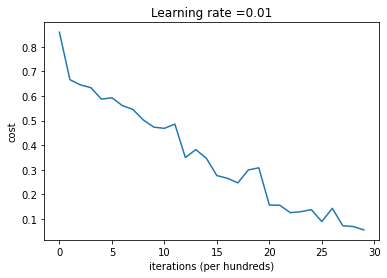

In [299]:
##  Backpropagation Regularization

def linear_backprop_reg(dZ, cache,lambd):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1/m * np.dot(dZ, A_prev.T) + lambd/m * W
    db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db


def linear_activation_backprop(dA, cache, activation):
    
    lin_cache , act_cache = cache
    
    if activation == "relu":
        
        dZ = relu_backprop(dA, act_cache)
        dA_prev, dW, db = linear_backprop_reg(dZ, lin_cache, 0.1)
    
    elif activation == 'sigmoid':
        
        dZ = sigmoid_backprop(dA, act_cache)
        dA_prev, dW, db = linear_backprop_reg(dZ, lin_cache, 0.1)
        
    return dA_prev, dW, db


def L_model_backprop(AL, Y, caches):
    


    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y,AL) - np.divide(1-Y, 1-AL))
    
    current_cache = caches[L - 1]
    dA_prev_temp , dW_temp, db_temp = linear_activation_backprop(dAL, current_cache,"sigmoid")
    grads['dA' + str( L - 1)] = dA_prev_temp
    grads['dW' + str(L)] = dW_temp
    grads['db' + str(L)] = db_temp
    
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp , db_temp = linear_activation_backprop(grads['dA' + str(l + 1)], current_cache,'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+ 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    
    return grads


def L_layer_model(X, Y, layers_dims, alpha = 0.01, num_iters = 3000, print_cost = False, initialization = "he"):
    costs = []
    
    if initialization == "zeros":
        parameters = initialize_params_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_params_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_params_He(layers_dims)
        
    for i in range(0,num_iters):
        AL, caches = L_model_forward(X, parameters)

        cost = cost_function_reg(AL, Y,parameters, 0.1)

        grads = L_model_backprop(AL, Y, caches)
        
        parameters = params_update(parameters, grads, alpha)
        
        if print_cost and i % 1000 == 0 or i == num_iters - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iters:
            costs.append(cost)
    
    return parameters, costs

def plot_costs(costs, alpha=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(alpha))
    plt.show()
    

layers_dims = [X.shape[0],30,15,1]

print("Initialization Regularized Back propagation")
parameters, costs = L_layer_model(X, y, layers_dims, num_iters = 3000, print_cost = True,initialization="he")
plot_costs(costs, 0.01)


### Neural Network Tunning methods
##### 3. Drop Out 


In [300]:
## Frontpropagation Regularization With Drop Out

def linear_forward(A, W, b):
        
    Z = W.dot(A) + b
    
    cache = (A,W,b)
    
    return Z, cache

# Activation Functions for NN
def sigmoid(Z):
    
    A= 1 / (1 + np.exp(-Z))
    cache = Z
    
    return A, cache

def Relu(Z):
    
    A = np.maximum(0,Z)
    cache = Z
    
    return A, cache

# Linear to Activation Layer
def linear_activation_forward_drop(A_prev, W, b, activation, keep_prop = 0.86):
    
    if activation == "sigmoid":
        
        Z, lin_cache = linear_forward(A_prev, W, b)
        A, act_cache = sigmoid(Z)
        cache = (lin_cache, act_cache)
        
    elif activation == "relu":
        
        Z, lin_cache = linear_forward(A_prev, W, b)
        A, act_cache = Relu(Z)
        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_prop).astype(int)
        A = D * A
        A = A / keep_prop
        cache = (lin_cache, act_cache, D)

    
    return A, cache

def L_model_forward_drop(X, params):
    
    caches =[]
    A = X
    L = len(params) // 2
    
    for l in range(1, L):
        
        A_prev = A
        # Using Relu Activation function in Hidden Layers
        A, cache = linear_activation_forward_drop(A_prev, params['W' + str(l)], params['b' + str(l)], "relu")
        caches.append(cache)
        

    Z, lin_cache = linear_forward(A,  params['W' + str(L)], params['b' + str(L)])
    AL, act_cache = sigmoid(Z)
    cache = (lin_cache, act_cache)
    caches.append(cache)

    return AL, caches


Network with Drop Out
Cost after iteration 0: 0.8022385818089317
Cost after iteration 1000: 0.517847984275403
Cost after iteration 2000: 0.3282486538990258
Cost after iteration 2999: 0.19781228094117145


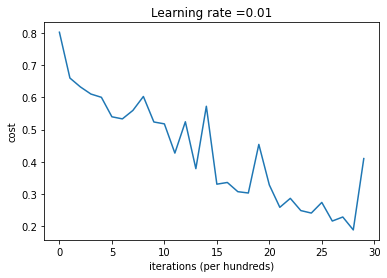

In [301]:
##  Backpropagation Regularization With Drop Out

def relu_backprop(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy = True)
    dZ[Z<= 0] = 0
    return dZ

def sigmoid_backprop(dA, cache):
    
    Z = cache
    s = 1/(1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    
    return dZ

def linear_backprop(dZ, cache,lambd):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1/m * np.dot(dZ, A_prev.T) 
    db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


def linear_activation_backprop_drop(dA, cache, activation, keep_prop = 0.86):
    
    if activation == "relu":
        lin_cache , act_cache, D = cache
        dZ = relu_backprop(dA, act_cache)
        dA_prev, dW, db = linear_backprop(dZ, lin_cache, 0.1)
        
    elif activation == 'sigmoid':
        lin_cache, act_cache = cache
        dZ = sigmoid_backprop(dA, act_cache)
        dA_prev, dW, db = linear_backprop(dZ, lin_cache, 0.1)
        
    return dA_prev, dW, db


def L_model_backprop_drop(AL, Y, caches,keep_prop = 0.86):
    
    grads = {}
    L = len(caches)
    m = AL.shape[1]

    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y,AL) - np.divide(1-Y, 1-AL))
    
    current_cache = caches[L - 1]
    cache2 = caches[L - 2]
    
    lin_cache , act_cache  = current_cache
    lin_cache2 , act_cache2 , D = cache2
    
    dA_prev_temp , dW_temp, db_temp = linear_activation_backprop_drop(dAL, current_cache,"sigmoid")
    dA_prev_temp = D * dA_prev_temp
    dA_prev_temp = dA_prev_temp / keep_prop
    grads['dA' + str( L - 1)] = dA_prev_temp
    grads['dW' + str(L)] = dW_temp
    grads['db' + str(L)] = db_temp
    
    for l in reversed(range(L - 1)):
        
        current_cache = caches[l]
        cache2 = caches[l - 1]
        dA_prev_temp, dW_temp , db_temp = linear_activation_backprop_drop(grads['dA' + str(l + 1)], current_cache,'relu')
        if l >= 2:
            dA_prev_temp = cache2[2] * dA_prev_temp
            dA_prev_temp = dA_prev_temp / keep_prop
        
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+ 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    
    return grads


def L_layer_model(X, Y, layers_dims, alpha = 0.01, num_iters = 3000, print_cost = False, initialization = "he"):
    costs = []
    
    if initialization == "zeros":
        parameters = initialize_params_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_params_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_params_He(layers_dims)
        
    for i in range(0,num_iters):
        AL, caches = L_model_forward_drop(X, parameters)

        cost = cost_function_reg(AL, Y,parameters, 0.1)
        
        grads = L_model_backprop_drop(AL, Y, caches)
        
        parameters = params_update(parameters, grads, alpha)
        
        if print_cost and i % 1000 == 0 or i == num_iters - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iters:
            costs.append(cost)
    
    return parameters, costs

def plot_costs(costs, alpha=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(alpha))
    plt.show()
    

layers_dims = [X.shape[0],30,15,1]

print("Network with Drop Out")
parameters, costs = L_layer_model(X, y, layers_dims, num_iters = 3000, print_cost = True,initialization="he")
plot_costs(costs, 0.01)


### Train the NN using training data

In [302]:
#Prediction accuracy on the Training dataset

pred_test = predict(X,y, parameters)

Accuracy: 0.9936708860759493


#### Test dataset

In [303]:
# set the test dataset with labels
TESTDIR = 'test'
test_set = []
def create_test_data():

    for ctg in CATEGORIES:
        path = os.path.join(TESTDIR, ctg)
        label = CATEGORIES.index(ctg)
        
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_set.append([new_array, label])

            
test_set = []
create_test_data()
random.shuffle(test_set)
len(test_set)

XX = []
yy = []

for features, labels in test_set:
    XX.append(features)
    yy.append(labels)
XX = np.array(XX)
XX = XX.reshape(XX.shape[0],-1).T
XX = XX/ 255

yy = np.array(yy)
yy = yy.reshape(1,yy.shape[0])

In [304]:
# Test on the test set

pred_train = predict(XX,yy, parameters)

Accuracy: 0.5921052631578947
